## Import Modules

In [25]:
import streamlit as st

# Streamlit UI
st.title('Image Captioning with Streamlit')

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Display the image
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    
    # Generate and display caption on button click
    if st.button('Generate Caption'):
        caption = predict_caption(image)
        st.write('Generated Caption:', caption)

# Footer
st.markdown('---')
st.markdown('**Note:** This is a demo for image captioning using a pre-trained model.')

2024-04-10 22:39:40.622 
  command:

    streamlit run C:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

In [1]:

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import torch

In [2]:
BASE_DIR = "C:/Users/USER/OneDrive/Documents/Flickr8k_Dataset"

## Extract Image Features

In [3]:

# Load a pre-trained Faster R-CNN model
new_model = fasterrcnn_resnet50_fpn(pretrained=True)


C:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

# Define a function to extract features using the Faster R-CNN model
def extract_features(image_path, model):
    # Load the image
    img = Image.open(image_path)
    # Transform the image (convert to tensor and normalize)
    img = F.to_tensor(img)
    img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Add a batch dimension
    img = img.unsqueeze(0)
    # Put the model in evaluation mode
    new_model.eval()
    with torch.no_grad():
        # Forward pass through the model
        outputs = new_model(img)
        boxes = outputs[0]['boxes'].cpu().numpy()
        features = boxes.flatten()
    return features

features = {}

#directory = os.path.join(BASE_DIR, 'Images')
directory = os.path.join(BASE_DIR)
for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    #img_path = os.path.join(directory, img_name)
    # Extract features using the Faster R-CNN model
    feature = extract_features(img_path, new_model)
    # Get image ID
    image_id = img_name.split('.')[0]
    # Store feature
    features[image_id] = feature



  0%|                                                                                         | 0/8091 [00:00<?, ?it/s]

In [6]:
len(features)

8091

In [ ]:
# Store features in a pickle file
pickle.dump(features, open(os.path.join(BASE_DIR, 'features_fasterrcnn_resnet50.pkl'), 'wb'))



In [36]:
# Load features from the pickle file for verification
with open(os.path.join('C:/Users/USER/OneDrive/Desktop/model/features_fasterrcnn_resnet50.pkl'), 'rb') as f:
    features = pickle.load(f)

In [37]:
features

{'10815824_2997e03d76': array([[ 8.940168  ,  6.3448    ,  8.094345  ,  0.        ,  0.        ,
          0.        ,  0.        , 14.448064  , 21.1387    ,  0.        ,
          0.        ,  0.        , 21.870867  ,  0.        , 11.461992  ,
          3.6038313 ,  7.732925  ,  0.        ,  0.        , 20.072237  ,
         18.18466   ,  0.        ,  0.        ,  0.        , 12.498613  ,
         12.667929  ,  5.2215223 ,  0.        ,  0.        , 29.581367  ,
          3.390169  ,  5.1110616 ,  1.1251476 ,  4.02166   ,  0.        ,
         26.391476  , 52.201366  , 14.340801  ,  3.477083  , 27.6662    ,
          0.        ,  0.        ,  6.123921  ,  0.        ,  0.        ,
         36.30507   , 16.364023  , 19.579054  ,  0.        ,  0.        ,
          2.9220119 , 38.791668  ,  2.935499  ,  0.        ,  0.        ,
          0.        , 15.117299  ,  0.        ,  0.        ,  5.302756  ,
          0.        , 50.246353  , 13.198734  ,  0.        ,  9.289043  ,
         15.007

## Load the Captions Data

In [38]:
with open(os.path.join("C:/Users/USER/OneDrive/Documents/Flickr8k_text/Flickr8k.token.txt"), 'r') as f:
    next(f)
    captions_doc = f.read()

In [39]:
from tqdm import tqdm

# Assuming captions_doc is the string containing the descriptions
mapping = {}

# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by tab(\t)
    tokens = line.split('\t')
    
    if len(tokens) != 2:
        continue
    
    image_id, captions = tokens[0], tokens[1].split('\t')
    
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    
    # add captions to the list
    mapping[image_id].extend(captions)

# Now, mapping contains image IDs mapped to a list of captions


100%|████████████████████████████████████████████████████████████████████████| 40455/40455 [00:00<00:00, 122933.33it/s]


In [40]:
len(mapping)

8091

In [41]:
mapping

{'1000268201_693b08cb0e': ['A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a girl with pigtails sitting in front of a rainbow painting .',
  'Young girl with

## Preprocess Text Data

In [42]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [43]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [44]:
# preprocess the text
clean(mapping)

In [45]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [47]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [48]:
len(all_captions)

40454

In [49]:
all_captions[:10]

['startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq']

In [50]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [51]:
vocab_size

8484

In [52]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

## Train Test Split

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [20]:
test

['436015762_8d0bae90c3',
 '436393371_822ee70952',
 '436608339_f1d1298770',
 '437054333_5c2761b8cd',
 '437404867_209625774d',
 '437527058_189f2a7eef',
 '437917001_ae1106f34e',
 '438639005_208bc59b0b',
 '439037721_cdf1fc7358',
 '439049388_3dcee2d30b',
 '439492931_a96d590e40',
 '439569646_c917f1bc78',
 '439916996_1ddb9dc8e7',
 '440184957_267f3f3a2b',
 '440190907_bf8b7ba8ef',
 '440737340_5af34ca9cf',
 '441212506_fcc321ac28',
 '44129946_9eeb385d77',
 '441398149_297146e38d',
 '441817653_fbdf83060b',
 '441921713_1cafc7d7d2',
 '442220883_ff3d6e507f',
 '442594271_2c3dd38483',
 '442918418_0f29c97fa9',
 '443430496_3fea95a07d',
 '443885436_6e927e6c58',
 '444047125_66b249287c',
 '444057017_f1e0fcaef7',
 '444481722_690d0cadcf',
 '444803340_fdcaab86f9',
 '444845904_a4531c811a',
 '444872454_9f51e07f88',
 '444881000_bba92e585c',
 '445148321_9f2f3ac711',
 '445655284_c29e6d7323',
 '445861800_75fc6a8c16',
 '446138054_d40c66d5f0',
 '446286714_dcec7f339e',
 '446291803_2fd4641b99',
 '446514680_ff5ca15ece',
 

In [21]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [22]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
#Model Training
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [ ]:
## train the model
epochs = 10
batch_size = 32
steps = len(train) // batch_size
steps_per_epoch = max(1, steps)
for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps_per_epoch, verbose=1)

In [26]:
# save the model
model.save("C:/Users/USER/Desktop"+'/best_model.h5')

C:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Generate Captions for the Image

In [53]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

## Test with Real Image

In [54]:
model1 = VGG16()
# restructure the model
model1 = Model(inputs=model1.inputs, outputs=model1.layers[-2].output)

In [55]:
def convert_to_speech(text):
    # Convert text to speech using gTTS
    tts = gTTS(text=text, lang='en')
    
    # Save the audio to a file
    tts.save('C:/Users/USER/OneDrive/Desktop/model/predicted_caption.mp3')
    
    # Play the audio
    os.system('C:/Users/USER/OneDrive/Desktop/model/predicted_caption.mp3')

In [56]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from gtts import gTTS 
import os
model = load_model("C:/Users/USER/Downloads/best_model.h5")
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 34)]                 0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 34, 256)              2171904   ['input_10[0][0]']            
                                                                                                  
 dropout_4 (Dropout)         (None, 4096)                 0         ['input_9[0][0]']             
                                                                                            

In [57]:
features1 = np.random.rand(1, 4096)  
features2 = np.random.rand(1, 4096)  
# Function to preprocess image
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image


In [58]:
def get_important_feature(model, image, tokenizer, max_length):
    caption = predict_caption(model, image, tokenizer, max_length)
    attention_weights = model.layers[-1].get_weights()[0]  # Assuming attention layer is the last layer
    attention_weights /= attention_weights.sum(axis=1, keepdims=True)
    image_features = model1.predict(image)
    weighted_features = np.squeeze(np.dot(attention_weights, image_features.T))
    
    # Find the most important feature
    important_feature_idx = np.argmax(weighted_features)
    
    return important_feature_idx, caption


In [59]:
# Function to predict caption for an image
def predict_caption(model, image_feature, tokenizer, max_length):
    caption = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image_feature,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        caption += ' ' + word
        if word == 'endseq':
            break
    return caption

In [60]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to extract features using VGG model
def feature_identification(image):
    image = preprocess_input(image)
    features = model1.predict(image)
    return features

1/1 [==============================] - 8s 8s/step


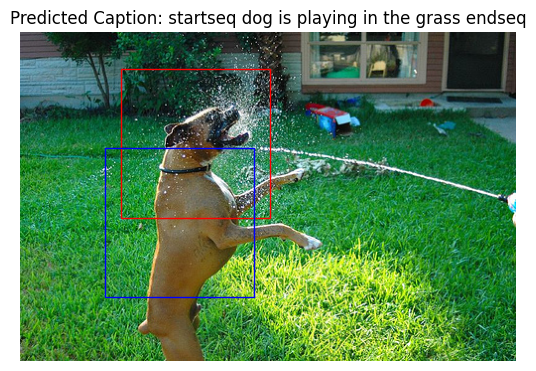

In [61]:

#image_path ="C:/Users/USER/OneDrive/Documents/Flickr8k_Dataset/"+test[1]+".jpg"
image_path = "C:/Users/USER/Downloads/44856031_0d82c2c7d1.jpg"
#image_path ="C:/Users/USER/Downloads/istockphoto-1490879216-1024x1024.jpg"

image = preprocess_image(image_path)
features = feature_identification(image)
features = features.reshape(1, 4096)  

# Predict caption for the image features
caption = predict_caption(model, features, tokenizer, max_length=34)

image = load_img(image_path)

plt.imshow(image)
plt.title('Predicted Caption: ' + caption)
plt.axis('off')
convert_to_speech(caption)

attention_weights = model.layers[-1].get_weights()[0]
important_feature_idx = np.argsort(attention_weights)[::-1][:2]

box_size = 150
x = (important_feature_idx[0][70]% 14) * 16 - box_size // 2
y = (important_feature_idx[0][700]%14) * 16 - box_size // 2
x1 = (important_feature_idx[1][80] % 14) * 16 - box_size // 2
y1 = (important_feature_idx[1][800] %14) * 16 - box_size // 2

rect = plt.Rectangle((x, y),box_size,box_size , edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)
rect = plt.Rectangle((x1, y1),box_size,box_size , edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect)
plt.show()

In [33]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_box(image_path, bounding_box):
    image = Image.open(image_path)
    fig, ax = plt.subplots()
    ax.imshow(image)
    rect = patches.Rectangle((bounding_box[0], bounding_box[1]), bounding_box[2]-bounding_box[0], bounding_box[3]-bounding_box[1],
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

1/1 [==============================] - 1s 509ms/step
Predicted Caption: startseq two men are playing in the grass endseq


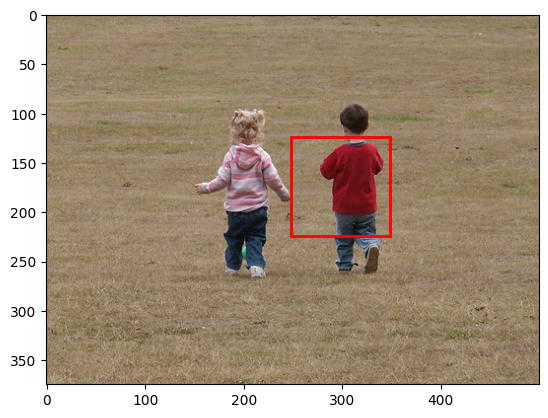

In [34]:
# Load the test image
test_image_path = "C:/Users/USER/OneDrive/Documents/Flickr8k_Dataset/"+test[7]+".jpg"
test_image = load_img(test_image_path, target_size=(224, 224))
test_image_array = img_to_array(test_image)
test_image_array = preprocess_input(test_image_array)
test_image_array = test_image_array.reshape((1, test_image_array.shape[0], test_image_array.shape[1], test_image_array.shape[2]))


test_feature = model1.predict(test_image_array)

predicted_caption = predict_caption(model, test_feature, tokenizer, max_length)
print("Predicted Caption:", predicted_caption)

image_width, image_height = test_image.size
feature_width, feature_height = 100, 100 
xmin = int(image_width - feature_width)*2
ymin = int(image_height - feature_height)
xmax = (xmin + feature_width)
ymax = (ymin + feature_height)

# Draw bounding box on the image
draw_bounding_box(test_image_path, (xmin, ymin, xmax, ymax))

In [107]:
from nltk.translate.bleu_score import corpus_bleu

# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features, tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU score
bleu_score = corpus_bleu(actual, predicted,weights=(1.0, 0, 0, 0))
print("BLEU-1:", bleu_score)
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.75, 0, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0, 1, 0, 0)))

100%|████████████████████████████████████████████████████████████████████████████████| 810/810 [12:59<00:00,  1.04it/s]


BLEU-1: 0.5637891687497705
BLEU-2: 0.264174
BLEU-3: 0.180833
BLEU-4: 0.123784


In [108]:
from nltk.translate.bleu_score import corpus_bleu

def tokenize_captions(captions):
    tokenized = [caption.split() for caption in captions]
    return tokenized

def calculate_recall_at_k(predicted_caption, ground_truth_captions, k):

    pred_tokens = predicted_caption.split()
    gt_tokens = tokenize_captions(ground_truth_captions)

    recall_k = 0
    for word in pred_tokens[:k]:
        for gt_caption in gt_tokens:
            if word in gt_caption:
                recall_k += 1
                break 
    
    recall_k /= len(gt_tokens)  
    return recall_k

recall_100, recall_50 = [], []
for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features, tokenizer, max_length)

    recall_100.append(calculate_recall_at_k(y_pred, captions, 100))

    recall_50.append(calculate_recall_at_k(y_pred, captions, 50))

avg_recall_100 = sum(recall_100) / len(recall_100)
avg_recall_50 = sum(recall_50) / len(recall_50)

print("Average Recall@1: {:.4f}".format(avg_recall_100))
print("Average Recall@5: {:.4f}".format(avg_recall_50))


100%|████████████████████████████████████████████████████████████████████████████████| 810/810 [13:15<00:00,  1.02it/s]

Average Recall@1: 0.9704
Average Recall@5: 0.9704


In [79]:
 import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [38]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [39]:
import nltk
from nltk import Tree

# Tokenize the caption
tokens = nltk.word_tokenize(caption)

# Perform part-of-speech tagging
tagged = nltk.pos_tag(tokens)

# Define a grammar for parsing
grammar = "NP: {<DT>?<JJ>*<NN>}"

# Create a parser with the defined grammar
cp = nltk.RegexpParser(grammar)

# Parse the tagged sentence
result = cp.parse(tagged)

# Function to recursively traverse the tree and format it
def to_nltk_tree(node):
    if isinstance(node, nltk.Tree):
        return Tree(node.label(), [to_nltk_tree(child) for child in node])
    else:
        return node

# Convert the result to an NLTK tree
tree = [to_nltk_tree(result)]

# Print the NLTK tree
for t in tree:
    t.pretty_print()


                              S                                          
   ___________________________|_____________________________________      
  |         |        |        NP       NP           NP              NP   
  |         |        |        |        |       _____|_____          |     
is/VBZ playing/VBG in/IN startseq/NN dog/NN the/DT     grass/NN endseq/NN



1/1 [==============================] - 1s 657ms/step


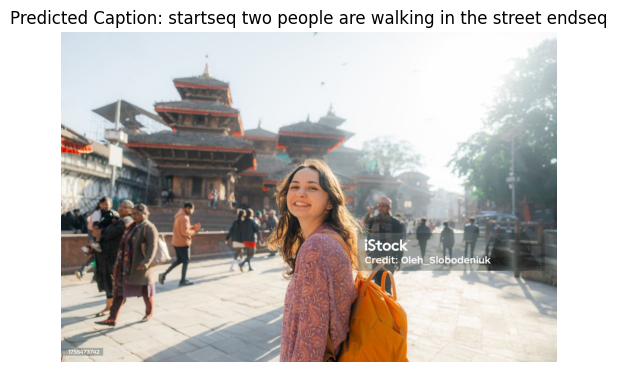

In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.text import Tokenizer


model = load_model("C:/Users/USER/Downloads/best_model.h5")
model1 = VGG16()
model1 = Model(inputs=model1.inputs, outputs=model1.layers[-2].output)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = 34

def preprocess_image(image_path):
    image = Image.open(image_path).resize((224, 224))
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

def feature_identification(image):
    image = preprocess_input(image)
    features = model1.predict(image)
    return features

def predict_caption(model, image_feature, tokenizer, max_length):
    caption = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image_feature,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        caption += ' ' + word
        if word == 'endseq':
            break
    return caption

# Function to get important feature based on attention
def get_important_feature(model, image, tokenizer, max_length):
    attention_weights = model.layers[-1].get_weights()[0] 
    attention_weights /= attention_weights.sum(axis=1, keepdims=True)
    image_features = model1.predict(image)
    weighted_features = np.squeeze(np.dot(attention_weights, image_features.T))
    important_feature_idx = np.argmax(weighted_features)
    
    return important_feature_idx, caption
    
def draw_bounding_box(image, important_feature_idx):
    box_size = 100 
    box_width = 100
    box_height = 50

    x = (important_feature_idx % 14) * 16 - box_size // 2
    y = (important_feature_idx // 14) * 16 - box_size // 2
    image_with_box = image.copy()
    cv2.rectangle(image_with_box, (x, y), (x + box_width, y + box_height), (255, 0, 0), 2)
    
    return image_with_box

def convert_to_speech(text):
    tts = gTTS(text=text, lang='en')
    tts.save('predicted_caption.mp3')
    os.system("start predicted_caption.mp3")

def choose_image():
    global image_label, image_path, model, tokenizer, max_length
    image_path = filedialog.askopenfilename(initialdir="/", title="Select Image",
                                            filetypes=(("JPEG files", "*.jpg"), ("All files", "*.*")))
    
    if image_path:
        image = preprocess_image(image_path)
        features = feature_identification(image)
        features = features.reshape(1, 4096)  
        caption = predict_caption(model, features, tokenizer, max_length=34)
        
        image = load_img(image_path)
        plt.imshow(image)
        plt.title('Predicted Caption: ' + caption)
        plt.axis('off')
        convert_to_speech(caption)
        attention_weights = model.layers[-1].get_weights()[0]
        important_feature_idx = np.argsort(attention_weights)[::-1][:2]
        img = Image.open(image_path)
        img = img.resize((400, 400))
        photo = ImageTk.PhotoImage(img)
        image_label.config(image=photo)
        image_label.image = photo
        

        #image_with_box = draw_bounding_box(np.array(img), 1000)
        #plt.imshow(image_with_box)
        #plt.axis('off')
        plt.show()
        convert_to_speech(caption)
        caption_label.config(text="Predicted Caption: " + caption)

root = tk.Tk()
root.title("Image Captioning")


image_label = tk.Label(root)
image_label.pack()


caption_label = tk.Label(root, text="")
caption_label.pack()


choose_button = tk.Button(root, text="Choose Image", command=choose_image)
choose_button.pack()

root.mainloop()
